In [61]:
# mount drive first
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
import os

ROOT = "/content/drive/MyDrive/Labelled"
CLASSES = os.listdir(ROOT)
CLASSES

['BrownSpot', 'Hispa', 'LeafBlast', 'Healthy', 'train', 'test']

In [ ]:
# def get_tt_path(class_name):
#   train_folder = os.path.join(ROOT, class_name, "train")
#   test_folder = os.path.join(ROOT, class_name, "test")
#   if not os.path.isdir(train_folder):
#     os.makedirs(train_folder)
#   if not os.path.isdir(test_folder):
#     os.makedirs(test_folder)
#   return train_folder, test_folder

# leafblast_train, leafblast_test = get_tt_path(CLASSES[0])
# healthy_train, healthy_test = get_tt_path(CLASSES[1])
# hidpa_train, hidpa_test = get_tt_path(CLASSES[2])
# brownSpot_train, brownSpot_test = get_tt_path(CLASSES[3])

In [ ]:
def get_tt(tt, class_name):
  # path = os.path.join(ROOT, class_name, tt)
  # if not os.path.isdir(path):
  #   os.makedirs(path)
  path = os.path.join(ROOT, tt, class_name)
  if not os.path.isdir(path):
    os.makedirs(path)
  return path

In [ ]:
from pathlib import Path
import shutil

def split_dataset(train_rate, class_name, reverse=False):
  original_path = os.path.join(ROOT, class_name)
  train_folder = get_tt("train", class_name)
  test_folder = get_tt("test", class_name)

  if reverse == True:
    train_files = [os.path.join(train_folder, f) for f in os.listdir(train_folder) if f.endswith(".jpg")]
    test_files = [os.path.join(test_folder, f) for f in os.listdir(test_folder) if f.endswith(".jpg")]

    for f in train_files:
      shutil.move(f, original_path)

    for f in test_files:
      shutil.move(f, original_path)

  else:
    image_files = [os.path.join(original_path, f) for f in os.listdir(original_path) if f.endswith(".jpg")]
    train_files = image_files[:int((len(image_files)+1)*train_rate)]
    test_files = image_files[int((len(image_files)+1)*train_rate):]

    for f in train_files:
      shutil.move(f, train_folder)

    for f in test_files:
      shutil.move(f, test_folder)

  print(class_name + " train folder file number:")
  print(len([f for f in os.listdir(train_folder)]))
  print(class_name + " test folder file number:")
  print(len([f for f in os.listdir(test_folder)]))

  return train_folder, test_folder

In [ ]:
TRAIN_RATE_1 = 0.7

leafblast_train1, leafblast_test1 = split_dataset(TRAIN_RATE_1, CLASSES[0])
healthy_train1, healthy_test1 = split_dataset(TRAIN_RATE_1, CLASSES[1])
hispa_train1, hispa_test1 = split_dataset(TRAIN_RATE_1, CLASSES[2])
brownSpot_train1, brownSpot_test1 = split_dataset(TRAIN_RATE_1, CLASSES[3])

BrownSpot train folder file number:
366
BrownSpot test folder file number:
157
Hispa train folder file number:
396
Hispa test folder file number:
169
LeafBlast train folder file number:
546
LeafBlast test folder file number:
233
Healthy train folder file number:
1042
Healthy test folder file number:
446


In [71]:
from keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = os.path.join(ROOT, "train")
TEST_DIR = os.path.join(ROOT, "test")

IMG_SIZE = (331, 331)

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1./127.5,
    horizontal_flip = True,
    rotation_range=20
    )
test_datagen = ImageDataGenerator(
    rescale=1./127.5,
    horizontal_flip = True,
    rotation_range=20
    )
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        TRAIN_DIR,
        # All images will be resized to 224x224
        target_size=IMG_SIZE,
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=IMG_SIZE,
        batch_size=20,
        class_mode='categorical')

Found 2350 images belonging to 4 classes.
Found 1005 images belonging to 4 classes.


In [64]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 331, 331, 3)
labels batch shape: (20, 4)


# VGG16

In [65]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from tensorflow.keras import optimizers

IMG_SIZE = (331, 331)
IMG_SHAPE = IMG_SIZE + (3,)

densenet169 = tf.keras.applications.DenseNet169(input_shape=IMG_SHAPE,
                                                include_top=False,
                                               weights='imagenet')

In [66]:
densenet169.trainable = False

In [67]:
model = keras.models.Sequential()
model.add(densenet169)
# Add the custom layers atop the VGG19 model: 
model.add(Flatten(name='flattened'))
# model.add(Dropout(0.5, name='dropout1'))
# model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3, name='dropout2'))
# model.add(Dense(1, activation='sigmoid', name='predictions'))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=0.0001),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [68]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 10, 10, 1664)      12642880  
                                                                 
 flattened (Flatten)         (None, 166400)            0         
                                                                 
 dropout2 (Dropout)          (None, 166400)            0         
                                                                 
 dense_5 (Dense)             (None, 4)                 665604    
                                                                 
Total params: 13,308,484
Trainable params: 665,604
Non-trainable params: 12,642,880
_________________________________________________________________


In [ ]:
dsn169_history = model.fit(
      train_generator,
      epochs=10,
      validation_data=test_generator)

Epoch 1/10
118/118 [==============================] - 1624s 14s/step - loss: 0.9374 - accuracy: 0.6894 - val_loss: 3.5409 - val_accuracy: 0.3692
Epoch 2/10
118/118 [==============================] - 1632s 14s/step - loss: 0.8825 - accuracy: 0.7311 - val_loss: 4.3448 - val_accuracy: 0.2667
Epoch 3/10
118/118 [==============================] - 1637s 14s/step - loss: 0.8322 - accuracy: 0.7281 - val_loss: 3.4176 - val_accuracy: 0.3881
Epoch 4/10
118/118 [==============================] - 1623s 14s/step - loss: 0.8075 - accuracy: 0.7417 - val_loss: 3.5177 - val_accuracy: 0.3532
Epoch 5/10
 63/118 [===============>..............] - ETA: 8:55 - loss: 0.7176 - accuracy: 0.7472

In [70]:
import matplotlib.pyplot as plt

dsn169_accuracy = dsn169_history.history['accuracy']
dsn169_val_acc = dsn169_history.history['val_accuracy']
dsn169_loss = dsn169_history.history['loss']
dsn169_val_loss = dsn169_history.history['val_loss']

epochs = range(len(dsn169_accuracy))

plt.plot(epochs, dsn169_accuracy, 'bo', label='Training acc')
plt.plot(epochs, dsn169_val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, dsn169_loss, 'bo', label='Training loss')
plt.plot(epochs, dsn169_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

NameError: ignored

In [ ]:
for layer in vgg16.layers:
    layer.trainable = False

In [ ]:
import keras
from tensorflow.keras import optimizers
# Instantiate the sequential model and add the VGG16 model: 
vgg_model1 = keras.models.Sequential()
vgg_model1.add(vgg16)
# Add the custom layers atop the VGG19 model: 
# vgg_model1.add(Flatten(name='flattened'))
# vgg_model1.add(Dropout(0.5, name='dropout1'))
# vgg_model1.add(Dense(512, activation='relu'))
# vgg_model1.add(Dropout(0.3, name='dropout2'))
# vgg_model1.add(Dense(1, activation='sigmoid', name='predictions'))
vgg_model1.add(Dense(3, activation='softmax', name='predictions'))
vgg_model1.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
vgg_model1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flattened (Flatten)         (None, 25088)             0         
                                                                 
 dropout1 (Dropout)          (None, 25088)             0         
                                                                 
 dense_7 (Dense)             (None, 512)               12845568  
                                                                 
 dropout2 (Dropout)          (None, 512)               0         
                                                                 
 predictions (Dense)         (None, 3)                 1539      
                                                                 
Total params: 27,561,795
Trainable params: 12,847,107

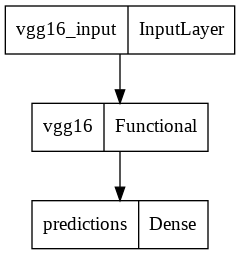

In [ ]:
plot_model(vgg_model1)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

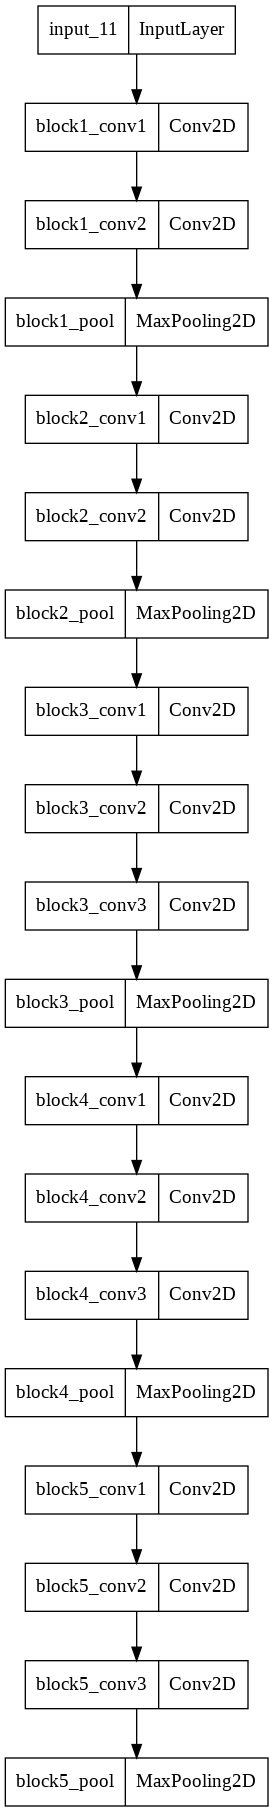

In [ ]:
base_vgg = VGG16(weights='imagenet', include_top = False)
base_vgg.summary()
plot_model(base_vgg)

In [ ]:
vgg_history = vgg_model1.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=test_generator,
      validation_steps=50)

Epoch 1/30


ValueError: ignored

In [ ]:
import matplotlib.pyplot as plt

vgg_accuracy = vgg_history.history['accuracy']
vgg_val_acc = vgg_history.history['val_accuracy']
vgg_loss = vgg_history.history['loss']
vgg_val_loss = vgg_history.history['val_loss']

epochs = range(len(vgg_accuracy))

plt.plot(epochs, vgg_accuracy, 'bo', label='Training acc')
plt.plot(epochs, vgg_val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, vgg_loss, 'bo', label='Training loss')
plt.plot(epochs, vgg_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# split_dataset(TRAIN_RATE_1, CLASSES[0], reverse=True)
# split_dataset(TRAIN_RATE_1, CLASSES[1], reverse=True)
# split_dataset(TRAIN_RATE_1, CLASSES[2], reverse=True)
# split_dataset(TRAIN_RATE_1, CLASSES[3], reverse=True)

In [ ]:
import pandas as pd

ROOT = "/content/drive/MyDrive/kaggle_bee_vs_wasp/"

meta_df = pd.read_csv(ROOT+'labels.csv')
meta_df.head()

,id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
0,1,bee1\10007154554_026417cfd0_n.jpg,1,0,0,0,1,0,0,bee
1,2,bee1\10024864894_6dc54d4b34_n.jpg,1,0,0,0,1,0,1,bee
2,3,bee1\10092043833_7306dfd1f0_n.jpg,1,0,0,0,1,1,0,bee
3,4,bee1\1011948979_fc3637e779_w.jpg,1,0,0,0,1,0,1,bee
4,5,bee1\10128235063_dca17db76c_n.jpg,1,0,0,0,1,0,0,bee


In [ ]:
meta_df[meta_df.isna().any(axis=1)]

,id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label


In [ ]:
def set_train_type(row):
    if row['is_validation'] == 0 and row['is_final_validation'] == 0:
        return 'train'
    return 'validation'

meta_df['type'] = meta_df.apply(set_train_type, axis=1)
print('Number values of each type')
meta_df['type'].value_counts()

Number values of each type


train         7939
validation    3482
Name: type, dtype: int64

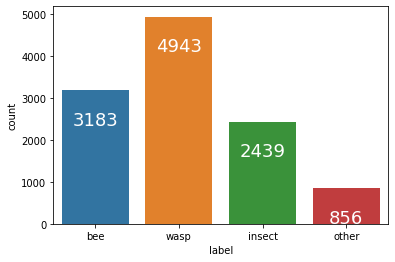

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.countplot(x="label", data=meta_df)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=18)
plt.show()

In [ ]:
import os

CLR_SUBDIR = "/content/drive/MyDrive/cavalcante/rust_xml_image/"
CLM_SUBDIR = "/content/drive/MyDrive/cavalcante/miner_img_xml/"

TARGET_SIZE1 = (300, 300)
TARGET_SIZE2 = (512, 512)

def get_all_with_ext(subdir, ext):
  return [f for f in os.listdir(subdir) if f.endswith(ext)]
  # paths = []
  # for f in os.listdir(subdir):
  #   if f.endswith(ext):
  #     paths.append(os.path.join(subdir,f))
  # return paths

clr_imgs = get_all_with_ext(CLR_SUBDIR, ".jpg")
clm_imgs = get_all_with_ext(CLM_SUBDIR, ".jpg")

print(len(clr_imgs))
print(len(clm_imgs))

285
257


In [ ]:
clr_xmls = get_all_with_ext(CLR_SUBDIR, ".xml")
clm_xmls = get_all_with_ext(CLM_SUBDIR, ".xml")

print(len(clr_xmls))
print(len(clm_xmls))

285
257


In [ ]:
import pandas as pd 
import os
import numpy as np 
import cv2
from keras.preprocessing import image 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from skimage.segmentation import mark_boundaries 

def get_image_value(path, dim): 
    '''This function will read an image and convert to a specified version and resize depending on which algorithm is being used. '''
    img = image.load_img(path, target_size = dim)
    img = image.img_to_array(img)
    return img/255

def get_img_array(img_paths, dim): 
    '''This fucntion takes a list of image paths and returns the np array corresponding to each image.  It also takes the dim and whether edge is specified in order to pass it to another function to apply these parameters.  This function uses get_image_value to perform these operations'''
    final_array = []
    from tqdm import tqdm
    for path in tqdm(img_paths):
        img = get_image_value(path, dim)
        final_array.append(img)
    final_array = np.array(final_array)  
    return final_array

In [ ]:
import tensorflow as tf
def get_tts(DIM):
    np.random.seed(10)

    clr_labels =  [0 for i in range(len(clr_imgs))]
    clm_labels =  [1 for i in range(len(clm_imgs))]

    np.random.shuffle(clr_imgs)
    np.random.shuffle(clm_imgs)

    paths = clr_imgs + clm_imgs
    labels = clr_labels + clm_labels
    print(tf.one_hot(labels, 2))
    # pistol_paths = [f'../Separated/FinalImages/Pistol/{i}' for i in os.listdir('../Separated/FinalImages/Pistol')] 
    # pistol_labels = [1 for i in range(len(pistol_paths))]
    # rifle_paths = [f'../Separated/FinalImages/Rifle/{i}' for i in os.listdir('../Separated/FinalImages/Rifle')] 
    # rifle_labels = [2 for i in range(len(rifle_paths))]    
    # neg_paths = [f'../Separated/FinalImages/NoWeapon/{i}' for i in os.listdir('../Separated/FinalImages/NoWeapon')]
    # np.random.shuffle(neg_paths)
    # neg_paths = neg_paths[:len(pistol_paths)- 500]
    # neg_labels = [0 for i in range(len(neg_paths))]

    # np.random.shuffle(pistol_paths)
    # pistol_paths = pistol_paths[:len(rifle_paths)+150]
    # neg_paths = neg_paths[:len(rifle_paths)+150]

    # pistol_labels = [1 for i in range(len(pistol_paths))]
    # rifle_labels = [2 for i in range(len(rifle_paths))]
    # neg_labels = [0 for i in range(len(neg_paths))]
    # paths = pistol_paths + rifle_paths + neg_paths
    # labels = pistol_labels + rifle_labels + neg_labels
    x_train, x_test, y_train, y_test = train_test_split(paths, labels, stratify = labels, train_size = .80, random_state = 10)

    new_x_train = get_img_array(x_train, DIM)
    new_x_test = get_img_array(x_test, DIM)
    
    print('Train Value Counts')
    print(pd.Series(y_train).value_counts())
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('Test Value Counts')
    print(pd.Series(y_test).value_counts())
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('X Train Shape')
    print(new_x_train.shape)
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('X Test Shape')
    print(new_x_test.shape)
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

    y_train = np.array(y_train)
    y_test = np.array(y_test)
    y_test = to_categorical(y_test)
    y_train = to_categorical(y_train)
    tts = (new_x_train, new_x_test, y_train, y_test)
    return tts

x_train, x_test, y_train, y_test = get_tts(TARGET_SIZE1)

tf.Tensor(
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]], shape=(542, 2), dtype=float32)


100%|██████████| 109/109 [01:18<00:00,  1.39it/s]

Train Value Counts
0    228
1    205
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Test Value Counts
0    57
1    52
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
X Train Shape
(433, 300, 300, 3)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
X Test Shape
(109, 300, 300, 3)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [ ]:
x_test.shape

(109, 300, 300, 3)

In [ ]:
y_test.shape

(109, 2)

In [ ]:
import numpy as np 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D, Dense, Dropout, Flatten 
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pandas as pd 
import matplotlib.pyplot as plt
import os
import pickle
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import cv2

def get_conv_model(dim = (300,300, 3)):
    '''This function will create and compile a CNN given the input dimension'''
    inp_shape = dim
    act = 'relu'
    drop = .25
    kernal_reg = regularizers.l1(.001)
    optimizer = Adam(lr = .0001)    
    model = Sequential() 
    model.add(Conv2D(64, kernel_size=(3,3),activation=act, input_shape = inp_shape, 
                     kernel_regularizer = kernal_reg,
                     kernel_initializer = 'he_uniform',  padding = 'same', name = 'Input_Layer'))
    model.add(MaxPooling2D(pool_size=(2, 2),  strides = (3,3)))
    model.add(Conv2D(64, (3, 3), activation=act, kernel_regularizer = kernal_reg, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (3,3))) 
    model.add(Conv2D(128, (3, 3), activation=act, kernel_regularizer = kernal_reg, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
    model.add(Conv2D(128, (3, 3), activation=act, kernel_regularizer = kernal_reg, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (3,3)))  
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(drop))
    model.add(Dense(1, activation='sigmoid', name = 'Output_Layer'))
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model 

In [ ]:
#prevents overfitting and saves models every time the validation loss improves
early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=10, min_delta = .00075)
model_checkpoint = ModelCheckpoint('ModelWeights.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')
epochs = 1000
batch_size = 32
model = get_conv_model()
model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (Conv2D)        (None, 300, 300, 64)      1792      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 100, 100, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 100, 100, 64)      36928     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 33, 33, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 33, 33, 128)       73856     
                                                                 
 conv2d_23 (Conv2D)          (None, 33, 33, 128)      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model_history = model.fit(x_train, y_train, batch_size = batch_size,
            epochs = epochs, 
     callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)

Epoch 1/1000


ValueError: ignored

In [ ]:
# Refered to https://machinelearningmastery.com/how-to-train-an-object-detection-model-with-keras/
# Combined with https://towardsdatascience.com/object-localization-using-pre-trained-cnn-models-such-as-mobilenet-resnet-xception-f8a5f6a0228d
import xml.etree.ElementTree as ET
from collections import namedtuple

Bounding_Box = namedtuple('Bounding_Box', 'xmin ymin xmax ymax')

def get_bounding_box(path_to_xml_annotation):
  tree = ET.parse(path_to_xml_annotation)
  root = tree.getroot()
  for box in root.findall('.//bndbox'):
    xmin = int(box.find('xmin').text)
    ymin = int(box.find('ymin').text)
    xmax = int(box.find('xmax').text)
    ymax = int(box.find('ymax').text)
  return Bounding_Box(xmin, ymin, xmax, ymax)

get_bounding_box(CLM_SUBDIR + 'bicho_mineiro0.xml')

Bounding_Box(xmin=739, ymin=1034, xmax=1252, ymax=1373)

In [ ]:
from PIL import Image, ImageOps
import numpy as np

def resize_image_with_bounds(path, sample_name, target_size, bounding_box=None):
  path_to_image = path + sample_name + ".jpg"
  path_to_xml = path + sample_name + ".xml"
  image = Image.open(path_to_image)
  width, height = image.size
  w_pad = 0
  h_pad = 0
  bonus_h_pad = 0
  bonus_w_pad = 0
  #the following code helps determining where to pad or is it not necessary for the images we have.
  # If the difference between the width and height was odd((height<width)case), we add one pixel on one side
  # If the difference between the height and width was odd((height>width)case), then we add one pixel on one side.
  #if both of these are not the case, then pads=0, no padding is needed, since the image is already a square itself.
  bounding_box = get_bounding_box(path_to_xml)
  if width > height:
    pix_diff = (width - height)
    h_pad = pix_diff // 2
    bonus_h_pad = pix_diff % 2
  elif height > width:
    pix_diff = (height - width)
    w_pad = pix_diff // 2
    bonus_w_pad = pix_diff % 2
  # When we pad the image to square, we need to adjust all the bounding box values by the amounts we added on the left or top.
  #The "bonus" pads are always done on the bottom and right so we can ignore them in terms of the box.
  image = ImageOps.expand(image, (w_pad, h_pad, w_pad+bonus_w_pad, h_pad+bonus_h_pad))
  if bounding_box is not None:
    new_xmin = bounding_box.xmin + w_pad
    new_xmax = bounding_box.xmax + w_pad
    new_ymin = bounding_box.ymin + h_pad
    new_ymax = bounding_box.ymax + h_pad
  # We need to also apply the scalr to the bounding box which we used in resizing the image
  if target_size is not None:
  # So, width and height have changed due to the padding resize.
    width, height = image.size
    image = image.resize(target_size)
    width_scale = target_size[0] / width
    height_scale = target_size[1] / height
  if bounding_box is not None:
    new_xmin = new_xmin * width_scale
    new_xmax = new_xmax * width_scale
    new_ymin = new_ymin * height_scale
    new_ymax = new_ymax * height_scale
  image_data = np.array(image.getdata()).reshape(image.size[0], image.size[1], 3)
  # The image data is a 3D array such that 3 channels ,RGB of target_size.(RGB values are 0-255)
  if bounding_box is None:
    return image_data, None
  return (image_data, Bounding_Box(new_xmin, new_ymin, new_xmax, new_ymax))

In [ ]:
def setting_sample_from_name(path, sample_name, target_size):
  path_to_image = os.path.join(path, sample_name + '.jpg')
  path_to_xml = os.path.join(path, sample_name + '.xml')
  original_bounding_box = get_bounding_box(path_to_xml)
  image_data, bounding_box = resize_image_with_bounds(path, sample_name, target_size, original_bounding_box)
  return (image_data, bounding_box)

In [ ]:
processed_size1 = []

# class 0 = CLR
# class 1 = CLM

for (img, xml) in zip(clr_imgs, clr_xmls):
    image, bounding_box = setting_sample_from_name(CLR_SUBDIR, os.path.splitext(img)[0], TARGET_SIZE1)
    img_tuple = (image, 0, bounding_box)
    processed_size1.append(img_tuple)

len(processed_size1)

285

In [ ]:
for (img, xml) in zip(clm_imgs, clm_xmls):
    image, bounding_box = setting_sample_from_name(CLM_SUBDIR, os.path.splitext(img)[0], TARGET_SIZE1)
    img_tuple = (image, 1, bounding_box)
    processed_size1.append(img_tuple)

len(processed_size1)

542

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

x_train = []
y_class_train = []
y_box_train = []
x_validation = []
y_class_validation = []
y_box_validation = []
validation_split = 0.2
for image, species, bounding_box in processed_size1:
  if np.random.random() > validation_split:
    x_train = np.append(x_train, preprocess_input(image))
    y_class_train = np.append(y_class_train, species)
    y_box_train = np.append(y_box_train, bounding_box)
  else:
    x_validation = np.append(x_validation, preprocess_input(image))
    y_class_validation = np.append(y_class_validation, species)
    y_box_validation = np.append(y_box_validation, bounding_box)
  x_train = np.array(x_train)
  y_class_train = np.array(y_class_train)
  y_box_train = np.array(y_box_train)
  x_validation = np.array(x_validation)
  y_class_validation = np.array(y_class_validation)
  y_box_validation = np.array(y_box_validation)

In [ ]:
print(type(x_train))
print(type(y_class_train))
print(type(y_box_train))
print(type(x_validation))
print(type(y_class_validation))
print(type(y_box_validation))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
print(x_train.shape)
print(y_class_train.shape)
print(y_box_train.shape)
print(x_validation.shape)
print(y_class_validation.shape)
print(y_box_validation.shape)


(119070000,)
(441,)
(1764,)
(27270000,)
(101,)
(404,)


In [ ]:
base_model1 = ResNet50(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE1[0], TARGET_SIZE1[1], 3))
chopped_resnet1 = Model(inputs=[base_model1.input], outputs=[base_model1.layers[90].output])
classification_output1 = GlobalAveragePooling2D()(chopped_resnet1.output)
classification_output1 = Dense(units=1, activation='sigmoid')(classification_output1)
localization_output1 = Flatten()(chopped_resnet1.output)
localization_output1 = Dense(units=4, activation='relu')(localization_output1)
model1 = Model(inputs=[chopped_resnet1.input], outputs=[classification_output1, localization_output1])
model1.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 306, 306, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 150, 150, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
model1.compile(optimizer='adam', metrics=['accuracy'],loss=['binary_crossentropy', 'mse'],loss_weights=[800, 1]  )
#lets run it through 10 epochs
history2=model1.fit(x_train, [y_class_train, y_box_train], validation_data=(x_validation, [y_class_validation, y_box_validation]),epochs=10,verbose=True)
history2

ValueError: ignored

In [ ]:
def plot_training_history(history, model):
plt.plot(history.history['dense_3_accuracy'])
plt.plot(history.history['val_dense_3_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()
plt.plot(history.history['dense_3_loss'])
plt.plot(history.history['val_dense_3_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()
plot_training_history(history2, model1)

In [ ]:
plot_training_history(history1, model)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_with_box(path, sample_name, target_size):
  image_data, bounding_box = resize_image_with_bounds(path, sample_name, target_size)
  fig,ax = plt.subplots(1)
  ax.imshow(image_data)
  # Creating a Rectangle patch for the changed one
  boxA = patches.Rectangle((bounding_box.xmin, bounding_box.ymin),
  bounding_box.xmax - bounding_box.xmin,
  bounding_box.ymax - bounding_box.ymin,
  linewidth=3, edgecolor='y', facecolor='none')
  # Add the patch to the Axes
  ax.add_patch(boxA)
  plt.show()

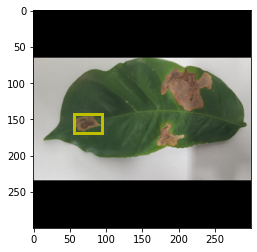

In [ ]:
plot_with_box(CLM_SUBDIR, "bicho_mineiro0", target_size=TARGET_SIZE1)

In [ ]:
import pandas as pd 
import os
import numpy as np 
import cv2
from keras.preprocessing import image 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from skimage.segmentation import mark_boundaries

def get_image_value(path, sample_name, dim): 
    '''This function will read an image and convert to a specified version and resize depending on which algorithm is being used. '''
    path_to_image = path + sample_name + ".jpg"
    img = image.load_img(path_to_image, target_size = dim)
    img = image.img_to_array(img)
    return img/255

def get_img_array(img_paths, dim): 
    '''This fucntion takes a list of image paths and returns the np array corresponding to each image.  It also takes the dim and whether edge is specified in order to pass it to another function to apply these parameters.  This function uses get_image_value to perform these operations'''
    final_array = []
    from tqdm import tqdm
    for path in tqdm(img_paths):
        img = get_image_value(path, dim)
        final_array.append(img)
    final_array = np.array(final_array)  
    return final_array

In [ ]:
get_image_value(CLM_SUBDIR, "bicho_mineiro0", TARGET_SIZE1)

array([[[0.74509805, 0.73333335, 0.7058824 ],
        [0.7529412 , 0.7411765 , 0.7137255 ],
        [0.7529412 , 0.7411765 , 0.7137255 ],
        ...,
        [0.8627451 , 0.85882354, 0.8509804 ],
        [0.8627451 , 0.85882354, 0.8509804 ],
        [0.85882354, 0.85490197, 0.84705883]],

       [[0.74509805, 0.73333335, 0.7137255 ],
        [0.7411765 , 0.7294118 , 0.70980394],
        [0.7490196 , 0.7372549 , 0.7176471 ],
        ...,
        [0.8666667 , 0.8627451 , 0.85490197],
        [0.85490197, 0.8509804 , 0.84313726],
        [0.85490197, 0.8509804 , 0.84313726]],

       [[0.73333335, 0.72156864, 0.7019608 ],
        [0.7490196 , 0.7372549 , 0.7176471 ],
        [0.7529412 , 0.7411765 , 0.7137255 ],
        ...,
        [0.85490197, 0.8509804 , 0.84313726],
        [0.85490197, 0.8509804 , 0.84313726],
        [0.8509804 , 0.84705883, 0.8392157 ]],

       ...,

       [[0.8627451 , 0.8627451 , 0.8627451 ],
        [0.85490197, 0.85490197, 0.85490197],
        [0.85882354, 0

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

x_train = []
y_class_train = []
y_box_train = []
x_validation = []
y_class_validation = []
y_box_validation = []
validation_split = 0.2
for image, species, bounding_box in processed_data:
  if np.random.random() > validation_split:
    x_train.append(preprocess_input(image))
    y_class_train.append(species)
    y_box_train.append(bounding_box)
  else:
    x_validation.append(preprocess_input(image))
    y_class_validation.append(species)
    y_box_validation.append(bounding_box)
    x_train = np.array(x_train)
    y_class_train = np.array(y_class_train)
    y_box_train = np.array(y_box_train)
    x_validation = np.array(x_validation)
    y_class_validation = np.array(y_class_validation)
    y_box_validation = np.array(y_box_validation)

NameError: ignored

In [ ]:
Detection = namedtuple("Detection", ["image_path", "gt", "pred"])



In [ ]:
from PIL import Image

def check_img_list_size(img_list, subdir):
    freq = {} 
    for img in img_list:
        im = Image.open(os.path.join(subdir, img))
        width, height = im.size
        dim = str(width) + "x" + str(height)
        if (dim in freq): 
            freq[dim] += 1
        else: 
            freq[dim] = 1
    return freq
        
check_img_list_size(clr_imgs, CLR_SUBDIR)

{'4000x2250': 275, '2549x3506': 7, '2250x4000': 3}

In [ ]:
check_img_list_size(clm_imgs, CLM_SUBDIR)

{'4000x2250': 257}

In [ ]:
# Refered to https://machinelearningmastery.com/how-to-train-an-object-detection-model-with-keras/

# function to extract bounding boxes from an annotation file
def extract_boxes(filename):
    # load and parse the file
    tree = ElementTree.parse(filename)
    # get the root of the document
    root = tree.getroot()
    # extract each bounding box
    boxes = list()
    for box in root.findall('.//bndbox'):
        xmin = int(box.find('xmin').text)
        ymin = int(box.find('ymin').text)
        xmax = int(box.find('xmax').text)
        ymax = int(box.find('ymax').text)
        coors = [xmin, ymin, xmax, ymax]
        boxes.append(coors)
    # extract image dimensions
    width = int(root.find('.//size/width').text)
    height = int(root.find('.//size/height').text)
    return boxes, width, height


In [ ]:
# extract details form annotation file
boxes, w, h = extract_boxes('cavalcante/miner_img_xml/bicho_mineiro0.xml')
# summarize extracted details
print(boxes, w, h)

[[2339, 163, 3299, 987], [2261, 1192, 2791, 1625], [739, 1034, 1252, 1373]] 4000 2250
